In [1]:
import sys,os,glob,copy
import numpy as np
import pyslha
import pandas as pd
import ROOT
import seaborn as sns
from collections import namedtuple
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d,griddata,LinearNDInterpolator
from ATLAS_data.effFunctions import (getMuonRecoEff,getTriggerEff,getTrackEff,
                                     getSelectionEff,getTargetMass,getMassSelEff)

# os.environ['ROOT_INCLUDE_PATH'] = os.path.abspath('./MG5/Delphes/external')

ROOT.gSystem.Load(os.path.abspath("./MG5/Delphes/libDelphes.so"))


ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "figure.figsize" : (8,6),
    "lines.linewidth" : 3.0,
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.24/06


In [2]:
inputFiles = {'stable' : './pp2C1N1/Events/run_02/10ns1300_delphes_events.root' }
# xsecsPB = {'stable' : 7.133e-3, 'prompt' : 7.133e-3}

In [3]:
modelInfoDict = {}
for label,f in inputFiles.items():
    if not os.path.isfile(f):
        print('File %s not found' %f)
        raise OSError()
    parsDict = {}    
    for banner in glob.glob(os.path.join(os.path.dirname(f),'*banner*txt')):
        with open(banner,'r') as ff:
            slhaData = ff.read().split('<slha>')[1].split('</slha>')[0]
            slhaData = pyslha.readSLHA(slhaData)
    parsDict = {}
    parsDict['mLLP'] = slhaData.blocks['MASS'][1000024]
    parsDict['mLSP'] = slhaData.blocks['MASS'][1000022]
    parsDict['width'] = slhaData.decays[1000024].totalwidth
    if parsDict['width']:
        parsDict['tau_ns'] = (6.582e-25/parsDict['width'])*1e9
    else:
        parsDict['tau_ns'] = np.inf    
    modelInfo = namedtuple('modelInfo', ' '.join(parsDict.keys()))
    m = modelInfo(**parsDict)
    modelInfoDict[label] = m
    print(label,':')
    print('mLLP = ',m.mLLP)
    print('tau (ns) = ',m.tau_ns)

stable :
mLLP =  1300.0
tau (ns) =  9.999999999999998


### Loop over events, apply basic selection criterium and compute masses

In [18]:
weightsDict = {}
massesDict = {}
gbetaDict = {}
metDict = {}
newMetDict = {}
metCaloDict = {}
genMetDict = {}

for label,inputFile in inputFiles.items():
    
    modelPars = modelInfoDict[label]

    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    
    gbetaDict[label] = []
    metDict[label] = []
    newMetDict[label] = []
    metCaloDict[label] = []
    genMetDict[label] = []
    weightsDict[label] = []
    isolation = []
    rdecay = []
    totalWeight = 0.0
    totalWeight60 = 0.0
    srWeights = {}
    
    acceptanceWeight = 0.0
    eventLevelWeight = 0.0
    srLowWeight = 0.0
    srHighWeight = 0.0

    weights = []
    masses = []
    nevts = 5000
    print('Reading %i events' %nevts)
    for ievt in range(nevts):
        tree.GetEntry(ievt)
        weight = tree.Event.At(0).Weight
        totalWeight += weight
        met = tree.MissingET.At(0).MET
        metCalo = tree.MissingETCalo.At(0).MET
        genMet = tree.GenMissingET.At(0).MET
        metDict[label].append(met)
        metCaloDict[label].append(metCalo)
        genMetDict[label].append(genMet)
        
        
        
        hscpCandidates = []
        charginos = []
        neutralinos = []
        for iptc in range(tree.Particle.GetEntries()):
            particle = tree.Particle.At(iptc)
            if abs(particle.PID) == 1000024 and particle.Status ==1:
                charginos.append(particle)
            elif abs(particle.PID) == 1000022 and particle.Status ==1:
                neutralinos.append(particle)
            # Get HSCP
            if abs(particle.Charge) != 1: # Skip neutral particles
                continue
            if particle.Mass < 20.: # Skip light (SM) particles
                continue
            if particle.Status != 1: # If HSCP is unstable check if it is the last step
                d1 = particle.D1
                d2 = particle.D2
                daughters = [tree.Particle.At(d) for d in range(d1,d2+1)]
                if any(daughter.PID == particle.PID for daughter in daughters):
                    continue
                # Get the HSCP decay radius from the first daughter production vertex:
                r_decay = np.sqrt(daughters[0].X**2 +daughters[0].Y**2)      
                z_decay = daughters[0].Z
            else:
                r_decay = np.inf
                z_decay = np.inf
                
            # Add decay position
            particle.r_decay = r_decay
            rdecay.append(r_decay)
            particle.z_decay = z_decay
            # Add beta and gamma*beta
            p = np.sqrt(particle.Px**2 +particle.Py**2 + particle.Pz**2)
            particle.beta = p/particle.E
            particle.gbeta = p/particle.Mass
            hscpCandidates.append(particle)
        
#         if len(charginos) != len(hscpCandidates):
#             print('Found %i charginos and %i HSCP candidates' %(len(charginos),len(hscpCandidates)))
#             break
            
        # Get gaugino pair pT
        px = sum([hscp.Px for hscp in hscpCandidates])+sum([n1.Px for n1 in neutralinos])
        py = sum([hscp.Py for hscp in hscpCandidates])+sum([n1.Py for n1 in neutralinos])
        gauginoPT = np.sqrt(px**2 + py**2)
        if gauginoPT > 60.:
            totalWeight60 += weight
            
        # Apply selection to HSCP candidates (following ATLAS snippet)
        hscpCandidates = [hscp for hscp in hscpCandidates[:] 
                          if (hscp.PT > 120. and abs(hscp.Eta) < 1.8 
                              and hscp.r_decay > 500.0)]
        
        if not hscpCandidates:
            continue
        
        if gauginoPT > 60.0:
            acceptanceWeight += weight       
            
        # Apply isolation requirement for HSCP tracks
        tracks = tree.Track
        for hscp in hscpCandidates:
            sumPT = 0.0
            for itrk in range(tracks.GetEntries()):
                track = tracks.At(itrk)
                if abs(track.PID) > 10000:
                    print(track.PID)
                deltaR = np.sqrt((track.Phi-hscp.Phi)**2 +(track.Eta-hscp.Eta)**2)
                if deltaR > 0.3:
                    continue
                sumPT += track.PT
            hscp.iso = sumPT
            isolation.append(sumPT)
        # Remove non-isolated HSCPs
#         hscpCandidates = [hscp for hscp in hscpCandidates[:] if hscp.iso < 5.0]
        
        if not hscpCandidates:
            continue
        
        hscps = hscpCandidates[:]
        muonsLLP = []
        # Get probability of tagging the HSCP as muon:
        for hscp in hscpCandidates:
            continue
            if hscp.r_decay < 3.9e3 and hscp.z_decay < 6e3: # Skip decays before MS
                continue
            beta = hscp.beta
            eta = abs(hscp.Eta)
            eff = getMuonRecoEff(beta,eta,hscp.PID)
            # Randomly reconstrunct the HSCP as a muon
            if np.random.uniform() < eff:
                muonsLLP.append(hscp)
        
        if muonsLLP:
            # Remove HSCPs:
            hscps = [hscp for hscp in hscps[:] if hscp not in muonsLLP]
            # Remove muonsLLp from MET:            
            pxTot = sum([m.Px for m in muonsLLP])
            pyTot = sum([m.Py for m in muonsLLP])
            metx = met*np.cos(tree.MissingET.At(0).Phi)
            mety = met*np.sin(tree.MissingET.At(0).Phi)
            newMet = np.sqrt((metx-pxTot)**2 + (mety-pyTot)**2)
            met = newMet
        newMetDict[label].append(met)

        triggerEff = getTriggerEff(metCalo)
        eventEff = getSelectionEff(met)
        if gauginoPT > 60.0:
            eventLevelWeight += weight*triggerEff*eventEff        
        
        
        if not hscps:
            continue         
#         if met < 170.0:
#             continue
            
        
        hscpEffs = {'SR-Inclusive_High' : [], 'SR-Inclusive_Low' : [], 'targetMass' : []}
        for hscp in hscps:
            gbeta = hscp.gbeta
            targetMass = getTargetMass(hscp.Mass)
            if targetMass is None:
                continue # Skip event if mass is outside all the mass windows
            trackEffHigh = getTrackEff(gbeta,sr='High')
            trackEffLow = getTrackEff(gbeta,sr='Low')
            wMassLow = getMassSelEff(targetMass,sr='Low')
            wMassHigh = getMassSelEff(targetMass,sr='High')
            hscpEffs['SR-Inclusive_High'].append(trackEffHigh*wMassHigh)
            hscpEffs['SR-Inclusive_Low'].append(trackEffLow*wMassLow)
            hscpEffs['targetMass'].append(targetMass)
            gbetaDict[label].append(gbeta)        
            
                      
        if not hscpEffs['targetMass']:
            continue
        
        # If the HSCPs have distinct masses, use the highest one:
        targetMass = max(hscpEffs['targetMass'])
        # Total event weight
        hscpLow = np.array(hscpEffs['SR-Inclusive_Low'])
        eventWeightLow = weight*triggerEff*eventEff*(1-np.prod(1.0-hscpLow))

        hscpHigh = np.array(hscpEffs['SR-Inclusive_High'])
        eventWeightHigh = weight*triggerEff*eventEff*(1-np.prod(1.0-hscpHigh))

        # Collect intermediate efficiencies for validation
        if gauginoPT > 60.0:
            srLowWeight += weight*triggerEff*eventEff*(1-np.prod(1.0-hscpLow/wMassLow))
            srHighWeight += weight*triggerEff*eventEff*(1-np.prod(1.0-hscpHigh/wMassHigh))
        
        
        if not targetMass in srWeights:
            srWeights[targetMass] = {'Low' : 0.0, 'High' : 0.0}
        srWeights[targetMass]['Low'] += eventWeightLow
        srWeights[targetMass]['High'] += eventWeightHigh

    # weights = np.array(weights)
    # masses = np.array(masses)
    # weightsDict[label] = weights
    # massesDict[label] = masses
print('Total cross-section = ',totalWeight/nevts)
print('SR=',srWeights)

Reading 5000 events
Total cross-section =  0.00012611798592843115
SR= {1600.0: {'Low': 0.004659272504941944, 'High': 0.014391183910452694}}


In [17]:
# Debug info:
# ATLAS values for stable charginos with mass = 600 GeV
# (S95_Low = 15, S95_High = 4.2, totalXsec = 2.85e-2 pb, xsecUL = 1.52e-3 pb, lumi = 139/fb)
print('Mass = %1.1f GeV, lifetime = %1.2f ns:' %(modelPars.mLLP,modelPars.tau_ns)) 
print('\t acceptance = %1.3f' %(acceptanceWeight/totalWeight60)) # 0.737
print('\t event-level efficiency = %1.3f' %(eventLevelWeight/acceptanceWeight)) # 0.156
print('\t efficiency for SR-Inclusive_High = %1.3f' %(srHighWeight/acceptanceWeight)) # 0.033
print('\t efficiency for SR-Inclusive_Low = %1.3f' %(srLowWeight/acceptanceWeight)) # 0.021

Mass = 1300.0 GeV, lifetime = 10.00 ns:
	 acceptance = 0.551
	 event-level efficiency = 0.196
	 efficiency for SR-Inclusive_High = 0.062
	 efficiency for SR-Inclusive_Low = 0.020


### Check ATLAS official values

In [7]:
charginoData = pd.read_pickle('./ATLAS_data/charginoData.pcl')
vals = charginoData[(charginoData['mass (GeV)'] == round(modelPars.mLLP,-2)) 
                    & (charginoData['lifetime (ns)'] == round(modelPars.tau_ns,0))]
vals

,mass (GeV),lifetime (ns),width (GeV),acceptance,event eff,SR-Inclusive_Low eff,SR-Inclusive_High eff,Expected Limit (pb),Observed Limit (pb),Signal Cross-Section (pb)
68,1300.0,10.0,6.582000e-17,0.634,0.395,0.061,0.146,0.000696,0.00164,0.000322


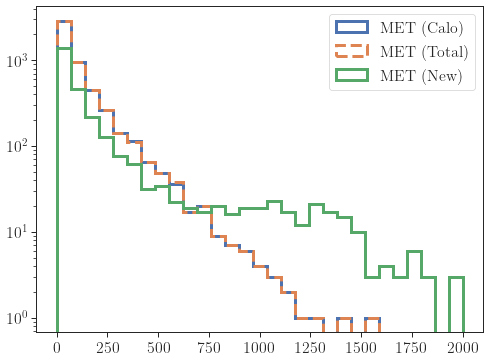

In [9]:
bins = np.linspace(0.,2000.,30)
plt.hist(metCaloDict['stable'],bins=bins,label='MET (Calo)',histtype='step',linewidth=3)
plt.hist(metDict['stable'],bins=bins,label='MET (Total)',histtype='step',linewidth=3,linestyle='--')
plt.hist(newMetDict['stable'],bins=bins,label='MET (New)',histtype='step',linewidth=3)
plt.yscale('log')
plt.legend()
plt.show()

In [10]:
print(np.array(metCaloDict['stable']).mean(),np.array(metCaloDict['stable']).std())

108.03028569395244 148.46983042851744


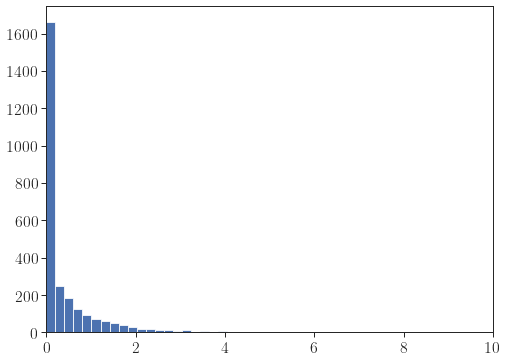

In [11]:
plt.hist(isolation,bins=np.linspace(0.,20.,100))
plt.xlim(0,10)
plt.show()

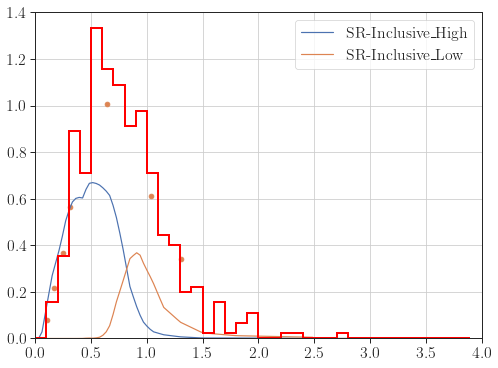

In [12]:
gbeta = np.linspace(0.,3.,100)
effHigh = [getTrackEff(gb,sr='High') for gb in gbeta]
effLow = [getTrackEff(gb,sr='Low') for gb in gbeta]
a = plt.plot(gbeta,effHigh,label='SR-Inclusive_High')
b = plt.plot(gbeta,effLow,label='SR-Inclusive_Low')
plt.hist(gbetaDict['stable'],bins=np.arange(0.,4.,0.1),
         density=True,histtype='step',color='red',linewidth=2)

atlas = np.array([[0.10317460317460325, 0.08475120385232726],[0.16666666666666652, 0.22589620117709996],
[0.2460317460317456, 0.3871589085072231],
[0.3095238095238093, 0.5957196361690746],
[0.6428571428571428, 1.0586409844836813],
[1.0396825396825395, 0.6447298020331731],
[1.3015873015873014, 0.35981808453718633]])

plt.scatter(atlas[:,0],0.95*atlas[:,1])
# plt.yscale('log')
plt.legend()
plt.xlim(0.,4.)
plt.grid()
plt.show()

In [ ]:
(6.582e-25/6.582e-17)*1e9